### Plot  data from Lamour et al. 

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import scipy.optimize as opt

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm

import functions_py.fates_xarray_functions as fa


In [2]:
dark = cm.get_cmap('Dark2', 8)
colormap = dark(range(8))

In [3]:
data = pd.read_csv('/global/homes/j/jneedham/plot_data/Data_Vertical_Profiles.csv')

data = data[(data.Life_form != "LIANA") & (data.Life_form != "HEMIEPIPHYTIC VINE") & (data.Life_form != "HERB") & (data.Life_form) & (data.LAI) & (data.Rdark25) & (data.Vcmax25)]


In [4]:
data =  data.dropna(subset=['LAI', 'Rdark25'])

### Lamour data using Atkin model

In [5]:
def func(x,a, b):
    return (a + b * x) * (1.7560 + 0.2061 * (0.033/0.012) + -0.0402 * max(0, (298.15 - 273.15)))

In [6]:
optimizedParameters, pcov = opt.curve_fit(func, data['LAI'], data['Rdark25'])

print(optimizedParameters)
                                          

[ 0.76775866 -0.07549542]


''

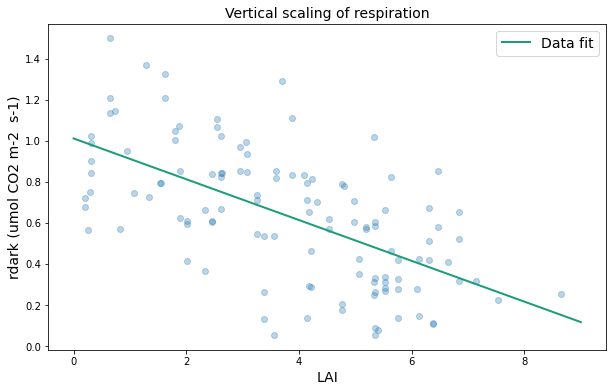

In [7]:
fig2, (f2ax0) = plt.subplots(nrows=1,ncols=1, figsize=(10,6))
 
f2ax0.scatter(data['LAI'], data['Rdark25'], alpha = 0.3)

lai = np.linspace(0,9,10)
f2ax0.plot(lai, func(lai, *optimizedParameters), color=colormap[0], linewidth=2, label = 'Data fit')

f2ax0.set_title(r'Vertical scaling of respiration', fontsize = 14)
f2ax0.set_ylabel(r'rdark (umol CO2 m-2  s-1)', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)
;

### Plot the four respiration schemes

In [8]:
lai = np.linspace(0,8,9)
r0 = 1.756
r1 = 0.2061
r2 = -0.0402
lnc_top = 0.033 / 0.012  # g N leaf / slatop 
vcmax25top = 50
tgrowth = 298.15
tfrz = 273.15

# Atkin
kn = np.exp(0.00963 * vcmax25top - 2.43)
nscaler = np.exp(-kn * lai)
lnc = lnc_top * nscaler
r_t_ref_atkin = r0 + r1 * lnc + r2 * max(0, (tgrowth - tfrz))

# Lamour
rdark_scaler_data = 0.76775866 + (-0.07549542 * lai)                                 
r_t_ref_lamour_data = rdark_scaler_data * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz)))  

# Negative exponential
rdark_scaler = 0.05 * -np.exp(lai * 0.3) + 1.05                                                                  
r_t_ref_negexp = rdark_scaler * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz)))
     
# lloyd
kn = np.exp(0.00963 * vcmax25top - 2.43)
nscaler = np.exp(-kn * lai)
r_t_ref_lloyd = nscaler * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz)))

lmr_atkin = r_t_ref_atkin * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 
lmr_lamour_data = r_t_ref_lamour_data * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2))
lmr_negexp =  r_t_ref_negexp * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 
lmr_lloyd = r_t_ref_lloyd * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 


''

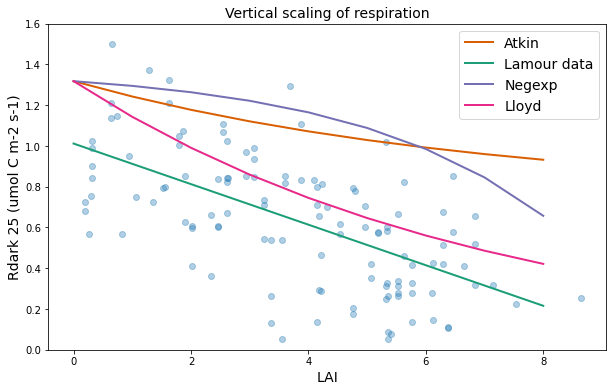

In [9]:
fig2, (f2ax0) = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    
f2ax0.scatter(data['LAI'], data['Rdark25'], alpha=0.35)
    
f2ax0.plot(lai, lmr_atkin,  label = 'Atkin', color=colormap[1], linewidth=2)
f2ax0.plot(lai, lmr_lamour_data,  label = 'Lamour data', color=colormap[0], linewidth=2)
f2ax0.plot(lai, lmr_negexp,  label = 'Negexp', color=colormap[2], linewidth=2)
f2ax0.plot(lai, lmr_lloyd,  label = 'Lloyd', color=colormap[3], linewidth=2)

f2ax0.set_title(r'Vertical scaling of respiration', fontsize = 14)
f2ax0.set_ylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)
f2ax0.set_ylim(0,1.6)
;

In [10]:
atkin_offset = lmr_atkin[0] - lmr_lamour_data[0]
lloyd_offset = lmr_lloyd[0] - lmr_lamour_data[0]
negexp_offset = lmr_negexp[0] - lmr_lamour_data[0]

In [11]:
lai = np.linspace(0,8,9)
r0 = 1.756
r1 = 0.2061
r2 = -0.0402
lnc_top = 0.033 / 0.012  # g N leaf / slatop 
vcmax25top = 50
tgrowth = 298.15
tfrz = 273.15

# Atkin
kn = np.exp(0.00963 * vcmax25top - 2.43)
nscaler = np.exp(-kn * lai)
lnc = lnc_top * nscaler
r_t_ref_atkin = r0 + r1 * lnc + r2 * max(0, (tgrowth - tfrz)) - atkin_offset

# Lamour
rdark_scaler = 0.76775866 + (-0.07549542  * lai)                                 
r_t_ref_lamour = rdark_scaler * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz)))  

# Negative exponential
rdark_scaler = 0.05 * -np.exp(lai * 0.3) + 1.05                                                                  
r_t_ref_negexp = rdark_scaler * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz))) - negexp_offset
     
# lloyd
kn = np.exp(0.00963 * vcmax25top - 2.43)
nscaler = np.exp(-kn * lai)
r_t_ref_lloyd = nscaler * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz))) - lloyd_offset

lmr_atkin = r_t_ref_atkin * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 
lmr_lamour = r_t_ref_lamour * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 
lmr_negexp =  r_t_ref_negexp * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 
lmr_lloyd = r_t_ref_lloyd * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 


''

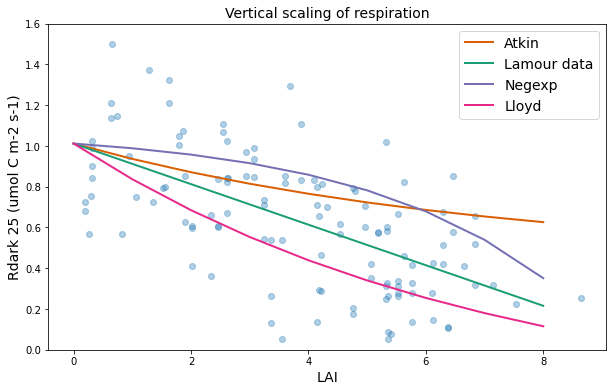

In [12]:
fig2, (f2ax0) = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    
f2ax0.scatter(data['LAI'], data['Rdark25'], alpha=0.35)
    
f2ax0.plot(lai, lmr_atkin,  label = 'Atkin', color=colormap[1], linewidth=2)
f2ax0.plot(lai, lmr_lamour_data,  label = 'Lamour data', color=colormap[0], linewidth=2)
f2ax0.plot(lai, lmr_negexp,  label = 'Negexp', color=colormap[2], linewidth=2)
f2ax0.plot(lai, lmr_lloyd,  label = 'Lloyd', color=colormap[3], linewidth=2)

f2ax0.set_title(r'Vertical scaling of respiration', fontsize = 14)
f2ax0.set_ylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)
f2ax0.set_ylim(0,1.6)
;

In [13]:
print(negexp_offset)
print(lloyd_offset)
print(atkin_offset)

0.3060418318185001
0.3060418318185001
0.3060418318185001
